# 目的
参考文献の内、
1.自分のジャーナルから/STS内から/外部からの割合の変化を時系列でみる
2.ジャーナルAが他のSTSジャーナルを引用した割合を求める

In [ ]:
%pip install pyalex
%pip install scikit-learn
from pyalex import Works, Authors, Sources, Institutions,Topics, Concepts, Funders
import pyalex,pandas as pd, numpy as np, matplotlib.pyplot as plt
pyalex.config.email = "miyabe-hiroki806@g.ecc.u-tokyo.ac.jp" # ここにあなたのメールアドレスを入力してください

from pyalex import config

config.max_retries = 3  # 最大再試行数を 3 回に設定
config.retry_backoff_factor = 1  # 再試行間隔を 0.1 秒に設定
config.retry_http_codes = [429, 500, 503]  # 再試行を行う HTTP エラーコードを指定

In [9]:

import matplotlib.patheffects as patheffects
import random,time,itertools,tqdm,collections
import pandas as pd
import numpy as np
import os
import re
import tqdm
import requests
from bs4 import BeautifulSoup
import pickle
from google.colab import drive
drive.mount('/content/drive')
flatten = lambda x: list(itertools.chain.from_iterable(x))



os.chdir("/content/drive/MyDrive/卒論/STS_ALL")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def getAll(pyalexObj):
    pager = pyalexObj.paginate(per_page=200,n_max=None)
    arr = []
    for page in tqdm.tqdm(pager):
        arr += page
    return arr

def get_tab20_color_hex(index):
    if index!=index:
        return None
    cmap = plt.get_cmap('tab20')
    actual_index = index % 20
    rgb_color = cmap(int(actual_index))[:3]  # Ignore the alpha value
    hex_color = '#%02x%02x%02x' % (int(rgb_color[0]*255), int(rgb_color[1]*255), int(rgb_color[2]*255))
    return hex_color

def get_journal_name_original(citing):
    '''
    citnig(列)：['primary_location']列しか取れない

    '''
    try:
        return citing['source']['display_name']
    except:
        return None

def get_topic(topic_raw,class_):
    '''
    topic()：['primary_location']列しか取れない
    class(str):domain,field,subfieldから選ぶ
    '''

    if class_ == "domain":
        try:
          return topic_raw['domain']["display_name"]

        except:
          return None

    elif class_ == "field":
        try:
          return topic_raw['field']["display_name"]

        except:
          return None

    elif class_ == "subfield":

        try:
         return topic_raw['subfield']["display_name"]

        except:
          return None






def remove_parentheses(text):
    """
    文字列から()で囲まれた部分を含む文字列を削除し、
    ()の前に半角スペースがある場合、そのスペースも削除する関数

    Parameters:
        text (str): 対象の文字列

    Returns:
        str: ()で囲まれた部分が削除された文字列
    """
    return re.sub(r'\s*\([^()]*\)', '', text)

def remove_parentheses(text):
    # 正規表現を使って()で囲まれた部分を検索し、削除する
    result = re.sub(r'\([^)]*\)', '', text)
    return result.strip()  # 削除後に余分な空白を削除して返す

def fetch_json_data(url):

    retries = 5

    '''
    url(str):APIのURL
    json_data(json):論文のデータ
    '''

    for _ in range(retries):

      try:
          response = requests.get(url)
          # ステータスコードが200以外の場合はエラーを発生させます
          response.raise_for_status()
          # JSONデータを取得します
          json_data = response.json()

          break

      except Exception as e:
            print(f"エラーが発生しました: {e}")
            print("リトライします...")
            time.sleep(5)
            continue

    return json_data


def fetch_all_results(url):
    url += "&per-page=200"
    results = []

    # リトライ回数
    retries = 5

    for _ in range(retries):
        try:
            # 初回のリクエストでカーソルを取得
            response = requests.get(url + "&cursor=*")
            data = response.json()

            # レスポンスから結果を取得
            if "results" in data:
                results += data["results"]

            # ページング情報を更新
            while "meta" in data and "next_cursor" in data["meta"]:
                next_cursor = data["meta"]["next_cursor"]
                response = requests.get(url + f"&cursor={next_cursor}")
                data = response.json()

                # レスポンスから結果を取得
                if "results" in data:
                    results += data["results"]

            # エラーが起きなかった場合はループを抜ける
            break
        except Exception as e:
            print(f"エラーが発生しました: {e}")
            print("リトライします...")
            time.sleep(5)
            continue

    return results





#journal
def get_journal_topic(url):
  api_url = "https://api.openalex.org/works/" + url.split("/")[-1]
  inf = fetch_json_data(api_url)
  journal = get_journal_name_original(inf["primary_location"])
  #たまにtopic列がないやつの方があるからtry文をかませる
  try:
    field = get_topic(inf["primary_topic"], class_="field")
    subfield = get_topic(inf["primary_topic"], class_="subfield")
  except Exception as error:
      field = None
      subfield = None

  return journal, field, subfield




# 2回目以降は省略

In [ ]:
cols = ["id",'cited_by_api_url',"publication_year","referenced_works","cited_by_count","primary_topic","primary_location","abstract_inverted_index"]

source_ids = [
    ##STS系
    "https://openalex.org/sources/s202144432", # Science, technology & society
    "https://openalex.org/sources/s2181421",   # Science, technology & human values
    "https://openalex.org/sources/s68632876",  # Social studies of science
    "https://openalex.org/sources/s104981805", # East Asian science, technology and society
    "https://openalex.org/sources/s190143089", # Science as culture
    "https://openalex.org/sources/s205537954", # Minerva
    #コミュニケーション系
    "https://openalex.org/sources/s124907306", # Public understanding of science
    "https://openalex.org/sources/s30803906",  # JCOM, journal of science communication
    "https://openalex.org/sources/s4210212669",# Science communication
    #計量系
    "https://openalex.org/sources/s16793705",  # Research Evaluation
    "https://openalex.org/sources/s9731383",   # Research policy
    "https://openalex.org/sources/s4210168539",# Science and public policy
    "https://openalex.org/sources/s148561398", # scientometorics
    #テクノロジー
    "https://openalex.org/sources/s70698675",  # technovation
    "https://openalex.org/sources/s149100181", # Technology in society
    "https://openalex.org/sources/s2764399430" # Journal of Responsible Innovation


]

In [ ]:
# LLM関連の2016年以降の論文を抽出。クエリは改善の余地あり
THRESHOLD = 1
pyalexObj = Works().filter(locations={"source":{"id":"|".join(source_ids)}}, cited_by_count=f">{THRESHOLD-1}",has_references="true").select(cols)
field_count = pyalexObj.count()
print(field_count)
works =  pd.DataFrame(getAll(pyalexObj)).drop_duplicates(subset=['id'])
print(f"取得した論文数/分野内の論文数：{len(works)}/{field_count} ({round(len(works)/field_count*100,2)}%)" )
# works.to_json("STS_All.json", orient="records")

24435


# dfの編集
* ジャーナル名を決める
* いらない列を削除
* 年代でグルーピング
* 例:2000-2010年の参考文献を調べるには2010年以前のIDが必要
* つまり作るべきは
1. 10年区切りのデータフレーム
2. 90年までのリスト、00年までのリスト、10年までのリスト、20年までのリスト、


In [ ]:
all_df = pd.read_json("/content/drive/MyDrive/卒論/STS_ALL/STS_All.json", orient="records")
all_df

,id,cited_by_api_url,publication_year,referenced_works,cited_by_count,primary_topic,primary_location,abstract_inverted_index
0,https://openalex.org/W2150220236,https://api.openalex.org/works?filter=cites:W2...,2009,"[https://openalex.org/W1585065401, https://ope...",9545,"{'id': 'https://openalex.org/T10799', 'display...","{'is_oa': True, 'landing_page_url': 'https://d...","{'We': [0], 'present': [1], 'VOSviewer,': [2],..."
1,https://openalex.org/W1971670344,https://api.openalex.org/works?filter=cites:W1...,1989,"[https://openalex.org/W1507129147, https://ope...",8137,"{'id': 'https://openalex.org/T10778', 'display...","{'is_oa': False, 'landing_page_url': 'https://...","{'Scientific': [0], 'work': [1, 44], 'is': [2]..."
2,https://openalex.org/W1992324015,https://api.openalex.org/works?filter=cites:W1...,1997,"[https://openalex.org/W1604285157, https://ope...",6354,"{'id': 'https://openalex.org/T12111', 'display...","{'is_oa': False, 'landing_page_url': 'https://...","{'The': [0], 'recognition': [1, 36, 143], 'and..."
3,https://openalex.org/W3125571233,https://api.openalex.org/works?filter=cites:W3...,1986,"[https://openalex.org/W1491554624, https://ope...",6345,"{'id': 'https://openalex.org/T10003', 'display...","{'is_oa': False, 'landing_page_url': 'https://...","{'This': [0, 84], 'paper': [1, 50, 106], 'atte..."
4,https://openalex.org/W2095197847,https://api.openalex.org/works?filter=cites:W2...,2000,"[https://openalex.org/W1532404490, https://ope...",5927,"{'id': 'https://openalex.org/T13276', 'display...","{'is_oa': False, 'landing_page_url': 'https://...","{'The': [0, 36, 82], 'Triple': [1], 'Helix': [..."
...,...,...,...,...,...,...,...,...
24430,https://openalex.org/W2094344888,https://api.openalex.org/works?filter=cites:W2...,1993,"[https://openalex.org/W108058141, https://open...",1,"{'id': 'https://openalex.org/T11572', 'display...","{'is_oa': False, 'landing_page_url': 'https://...","{'lt': [0], 'has': [1, 131], 'been': [2, 44, 1..."
24431,https://openalex.org/W2119286403,https://api.openalex.org/works?filter=cites:W2...,1992,[https://openalex.org/W1506507748],1,"{'id': 'https://openalex.org/T13284', 'display...","{'is_oa': False, 'landing_page_url': 'https://...",None
24432,https://openalex.org/W2345318553,https://api.openalex.org/works?filter=cites:W2...,1993,"[https://openalex.org/W1773552906, https://ope...",1,"{'id': 'https://openalex.org/T11649', 'display...","{'is_oa': False, 'landing_page_url': 'https://...","{'Though': [0], 'acne': [1], 'is': [2, 8], 'no..."
24433,https://openalex.org/W2431369270,https://api.openalex.org/works?filter=cites:W2...,1994,[https://openalex.org/W4300668223],1,"{'id': 'https://openalex.org/T13085', 'display...","{'is_oa': False, 'landing_page_url': 'https://...","{'This': [0], 'paper': [1], 'summarizes': [2],..."


In [ ]:
#ジャーナル名を追加
all_df["journal_name"] = all_df["primary_location"].apply(get_journal_name_original).apply(remove_parentheses)

#不要な列を削除
all_df = all_df.drop(['cited_by_api_url', 'primary_topic', 'abstract_inverted_index',"primary_location"] ,axis=1)


In [ ]:
#IDと ジャーナル名の辞書を作成
keys =  all_df["id"].to_list()
values = all_df["journal_name"].to_list()
id_journal= dict(zip(keys , values))

In [ ]:
#年代ごとにdfを分割
df_1990s = all_df[(all_df["publication_year"] < 2000) & (all_df["publication_year"] > 1989)].explode(column="referenced_works")
df_2000s = all_df[(all_df["publication_year"] < 2010) & (all_df["publication_year"] > 1999)].explode(column="referenced_works")
df_2010s = all_df[(all_df["publication_year"] < 2020) & (all_df["publication_year"] > 2009)].explode(column="referenced_works")
df_2020s = all_df[all_df["publication_year"] > 2019].explode(column="referenced_works")

In [ ]:
year = 1990
dfs = [df_1990s,df_2000s, df_2010s, df_2020s]
#参考文献の論文のジャーナル名を追加
for df in dfs:
  df.reset_index(drop=True, inplace=True)
  for i in  tqdm.tqdm(range(df.shape[0])):
    #参考文献の論文がSTS論文に含まれていれば、ジャーナル名を追加
    if df.at[i, "referenced_works"] in id_journal:
      df.at[i, "ref_journal"] =  id_journal[df.at[i, "referenced_works"]]
    else :
      df.at[i, "ref_journal"] =  "other"

  #ジャーナル名を略記に変換
  for col in ["journal_name",'ref_journal']:
    df.loc[df[col] == 'Social studies of science', col] = 'SSS'

    df.loc[df[col] == 'Science, technology & human values/Science, technology, & human values', col] = 'STHV'

    df.loc[df[col] == 'Public understanding of science', col] = 'PUS'

    df.loc[df[col] == 'Science as culture',col] = 'SasC'

    df.loc[df[col] == 'Research policy', col] = 'RePoli'

    df.loc[df[col] == 'Science, technology & society', col] = 'STS'

    df.loc[df[col] == 'Research evaluation', col] = 'ReEval'

    df.loc[df[col] == 'East Asian science, technology and society', col] = 'EASTS'

    df.loc[df[col] == 'Science communication', col] = 'SciCom'

    df.loc[df[col] == 'Journal of responsible innovation', col] = 'JRI'

    df.loc[df[col] == 'Technology in society', col] = 'TIS'

    df.loc[df[col] == 'Science and public policy/Science & public policy', col] = 'SPP'

    df.loc[df[col] ==  'JCOM, journal of science communication', col] = 'JCOM'

  df.to_json(f"ref_df_{year}s.json", orient="records")
  year += 10


100%|██████████| 304101/304101 [00:20<00:00, 14828.21it/s]


# ジャーナル名ごとのbag of wordsをつくる

In [ ]:
df_1990s = pd.read_json("/content/drive/MyDrive/卒論/STS_ALL/ref_df_1990s.json", orient="records")
df_2000s = pd.read_json("/content/drive/MyDrive/卒論/STS_ALL/ref_df_2000s.json", orient="records")
df_2010s = pd.read_json("/content/drive/MyDrive/卒論/STS_ALL/ref_df_2010s.json", orient="records")
df_2020s = pd.read_json("/content/drive/MyDrive/卒論/STS_ALL/ref_df_2020s.json", orient="records")

In [ ]:
import pandas as pd
dfs = [df_1990s,df_2000s, df_2010s, df_2020s]
bag_of_journals = []

for df in dfs:
  # journal_name列でグルーピングし、ref_journalの組み合わせをカウント
  grouped = df.groupby(['journal_name', 'ref_journal']).size().reset_index(name='count')

  # 結果をpivotテーブルに変換して、新しいデータフレームに整理
  pivot_df = grouped.pivot(index='journal_name', columns='ref_journal', values='count').fillna(0)

  # 列名をリストにして新しいデータフレームの列名として設定
  columns = sorted(df['journal_name'].unique().tolist() + ['other'])
  pivot_df = pivot_df.reindex(columns=columns, fill_value=0).reset_index()
  pivot_df = pivot_df.applymap(lambda x: int(x) if isinstance(x, float) else x)

  # 結果を表示
  bag_of_journals.append(pivot_df)


In [ ]:
year = 1990
for df in bag_of_journals:
  df.to_json(f"BagOfJournal{year}s.json", orient="records")
  year +=10

In [ ]:
bag_of_journals[2]

ref_journal,journal_name,EASTS,JCOM,JRI,Minerva,PUS,ReEval,RePoli,SPP,SSS,STHV,STS,SasC,SciCom,Scientometrics,TIS,Technovation,other
0,EASTS,257,2,0,12,52,0,31,7,150,70,24,43,25,28,9,2,6340
1,JCOM,1,21,0,0,97,0,9,3,16,6,1,6,58,4,1,3,1499
2,JRI,2,0,506,24,65,15,145,77,87,102,1,38,18,6,60,5,4734
3,Minerva,3,4,7,278,44,55,366,105,225,154,15,24,16,147,16,18,7766
4,PUS,16,31,7,22,2245,1,30,64,247,297,27,104,535,15,11,1,14027
5,ReEval,0,0,4,83,5,622,709,164,61,38,4,1,14,829,5,66,6959
6,RePoli,5,0,18,97,28,192,11756,256,257,170,34,13,16,906,75,641,73449
7,SPP,7,2,20,124,164,175,2208,821,171,211,40,25,77,478,53,233,16060
8,SSS,27,2,5,41,80,11,120,28,1440,370,11,112,20,38,14,4,15989
9,STHV,20,1,5,50,139,11,123,31,617,775,11,112,29,32,16,1,14522


# 自分のジャーナル/STS内/その他の割合

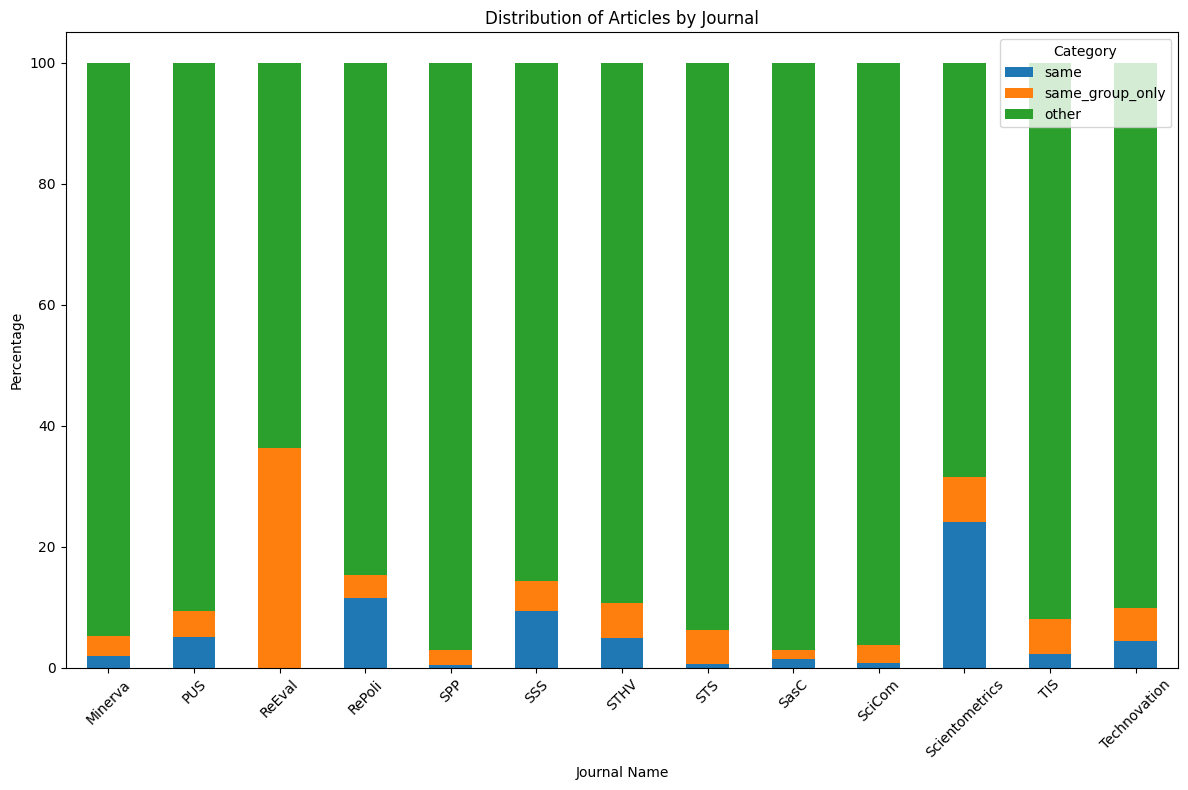

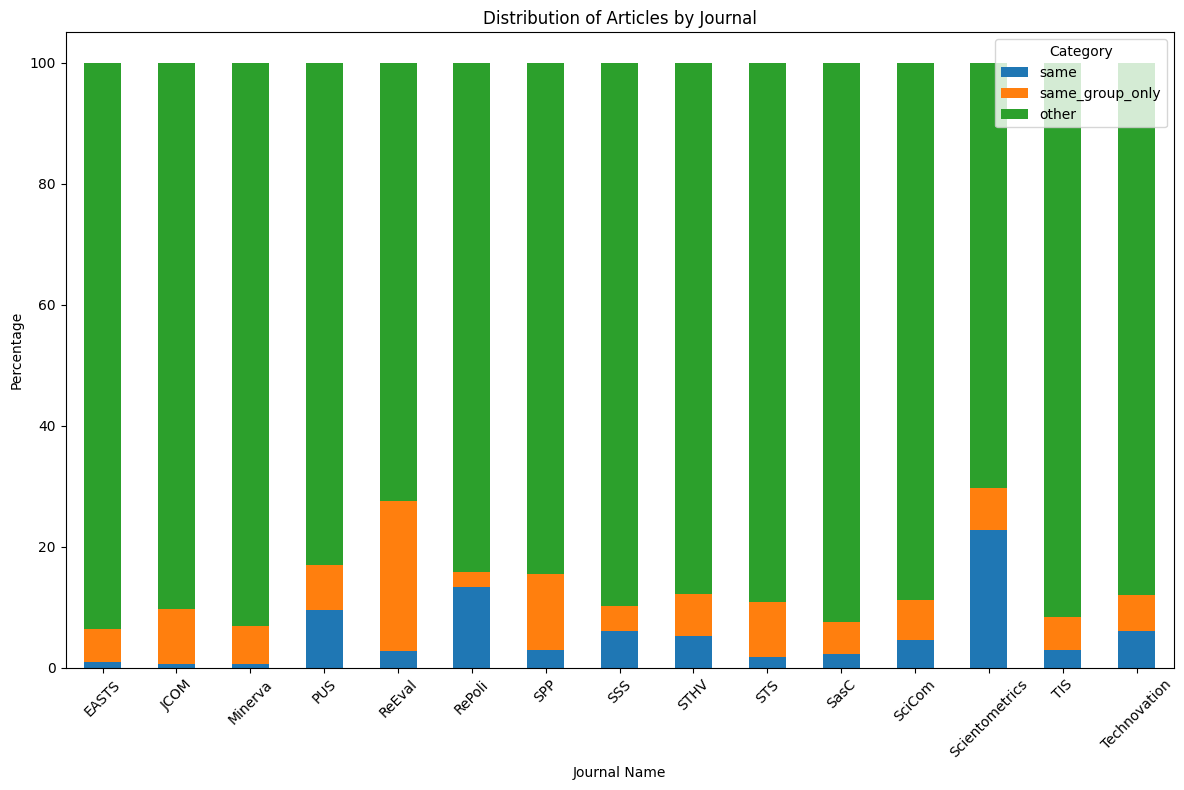

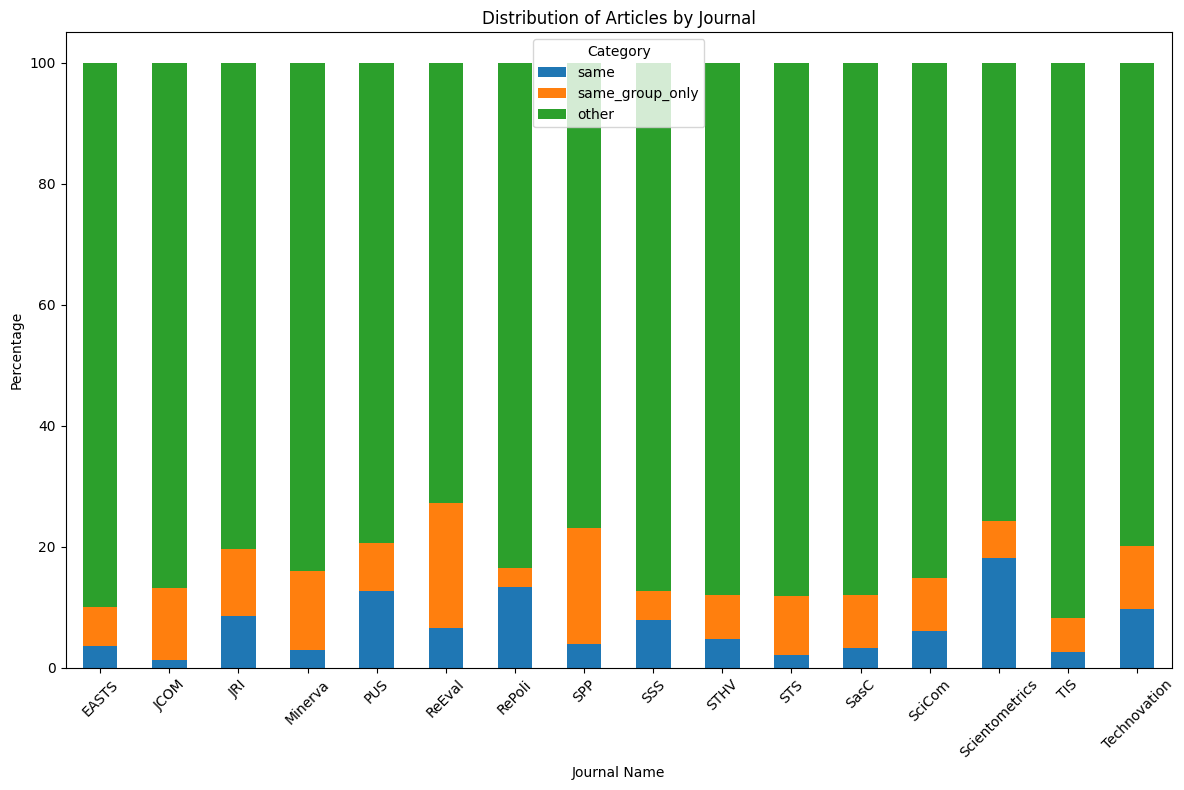

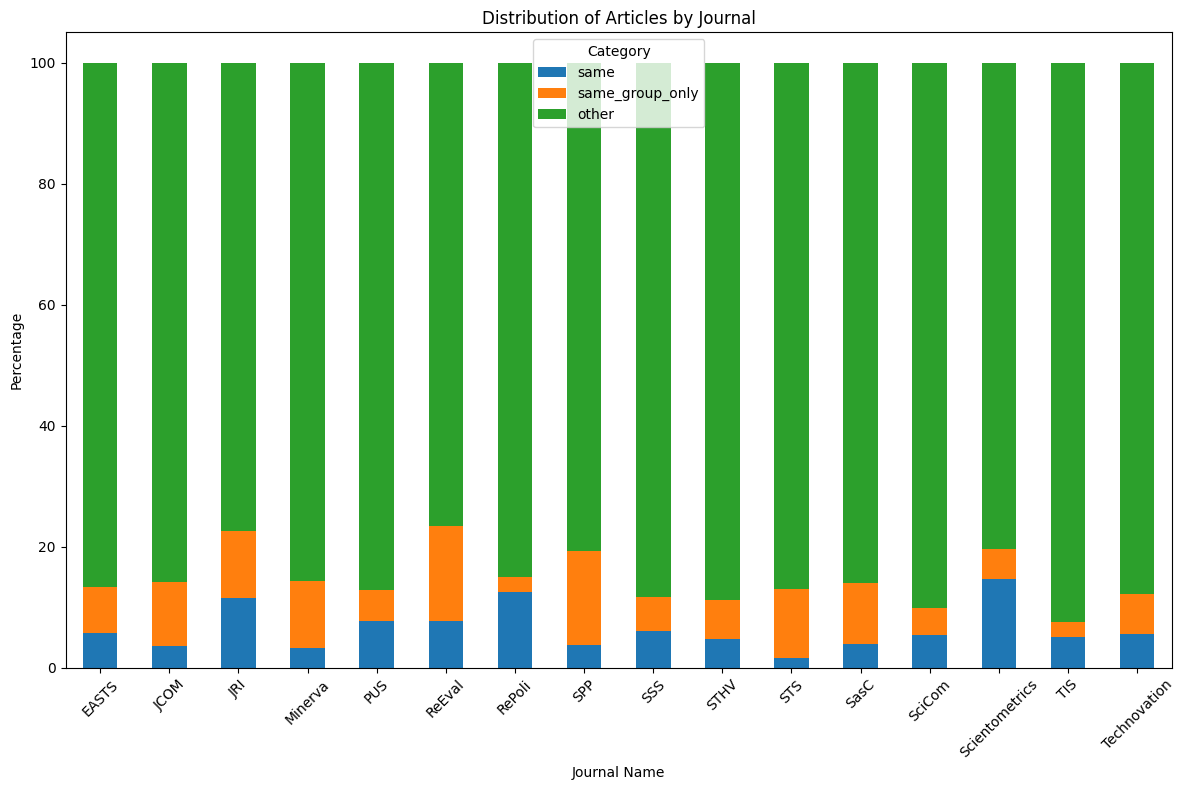

In [ ]:
#同じジャーナル内のRefernece
dfs = [df_1990s,df_2000s, df_2010s, df_2020s]
for df in dfs:
  same_count = df.groupby("journal_name").apply(lambda x: (x["journal_name"] == x["ref_journal"]).sum()).reset_index(name="same")
  #STSジャーナル内のRefernece
  same_group_count = df.groupby("journal_name").apply(lambda x: x["ref_journal"].isin(df["journal_name"].unique().tolist()).sum()).reset_index(name="same_group")
  #STSジャーナル外のRefernece
  other_count = df.groupby("journal_name").apply(lambda x: (~x["ref_journal"].isin(df["journal_name"].unique().tolist())).sum()).reset_index(name="other")
  new_df = pd.merge(same_count, same_group_count, on="journal_name")
  new_df = pd.merge(new_df, other_count, on="journal_name")
  # 各行の総和を示す列を追加

  new_df["total"] = new_df.iloc[:, 2:].sum(axis=1)
  #調整
  new_df['same_group_only'] = new_df['same_group'] - new_df['same']
  new_df = new_df.drop('same_group', axis=1)
  new_df = new_df[["journal_name","same","same_group_only","other","total"]]

  # パーセントのデータフレームを作成
  percent_df = new_df.copy()
  percent_df.iloc[:, 1:-1] = (percent_df.iloc[:, 1:-1].div(percent_df["total"], axis=0) * 100)


  fig, ax = plt.subplots(figsize=(12, 8))

  # 積み上げ棒グラフを作成
  percent_df.plot(kind='bar', x='journal_name', y=['same', 'same_group_only', 'other'], stacked=True, ax=ax)

  # ラベルとタイトルを設定
  ax.set_xlabel('Journal Name')
  ax.set_ylabel('Percentage')
  ax.set_title('Distribution of Articles by Journal')
  plt.xticks(rotation=45)
  plt.legend(title='Category')

  # グラフを表示
  plt.tight_layout()
  plt.show()

# 変遷

In [7]:
BOJ1990 = pd.read_json("BagOfJournal1990s.json", orient="records")
BOJ2000 = pd.read_json("BagOfJournal2000s.json", orient="records")
BOJ2010 = pd.read_json("BagOfJournal2010s.json", orient="records")
BOJ2020 = pd.read_json("BagOfJournal2020s.json", orient="records")

In [10]:
#BOJ1990をBOJ2020にconcatできるように整形
for col in ["EASTS","JCOM","JRI"]:
  BOJ1990[col] = [0]*13
BOJ1990 = BOJ1990[BOJ2020.columns.to_list()]

ad_df = pd.DataFrame(np.zeros((3, 17)))
ad_df = ad_df.applymap(lambda x: int(x) if isinstance(x, float) else x)
ad_df.columns =[ 'EASTS', 'JCOM', 'JRI', 'Minerva', 'PUS', 'ReEval',
       'RePoli', 'SPP', 'SSS', 'STHV', 'STS', 'SasC', 'SciCom',
       'Scientometrics', 'TIS', 'Technovation', 'other']
ad_df.insert(0, 'journal_name', ["EASTS","JCOM","JRI"])


BOJ1990 = pd.concat(
    [ad_df, BOJ1990],
    axis=0,
    ignore_index=True
)

In [11]:
#BOJ2000をBOJ2020にconcatできるように整形
#列を追加
BOJ2000["JRI"] = [0]*15
BOJ2000 = BOJ2000[BOJ2020.columns.to_list()]

#挿入したい行で分裂させる
df_former = BOJ2000.iloc[:2,:]
df_latter = BOJ2000.iloc[2:,:]


#BOJ19901のJRI列を借りてくるが、seriesなのでデータフレームにしてから転地する必要がある
df_former = pd.concat(
    [df_former, BOJ1990.iloc[2,:].to_frame().T],
    axis=0,
    ignore_index=True
)


BOJ2000 = pd.concat(
    [df_former, df_latter],
    axis=0,
    ignore_index=True
)

In [12]:
#indexを作るための辞書
dic = {}
lst = ["1990s", "2000s", "2010s", "2020s"]
for i in range(4):
  dic[i] = lst[i]

#各年代のあるジャーナルの組成持ってきて、concatで組み合わせる
df_dict = {}
for i, journal in enumerate(BOJ2020["journal_name"].to_list()):
  df = pd.concat(
    [BOJ1990.iloc[i, :].to_frame().T,
     BOJ2000.iloc[i, :].to_frame().T,
     BOJ2010.iloc[i, :].to_frame().T,
     BOJ2020.iloc[i, :].to_frame().T],
    axis=0,
    ignore_index=True)
  df = df.rename(index=dic).drop("other", axis=1)
  df["Total"] = df.iloc[:, 1:].sum(axis=1)

  df_dict[journal] = df

In [13]:
#パーセンタイルにする
percent_df_dict = {}
for journal in list(df_dict):
  df = df_dict[journal]
  df_ratio = (df.iloc[:, 1:].div(df['Total'], axis=0) * 100).fillna(0).round(1)
  percent_df_dict[journal] = df_ratio

In [14]:

os.chdir("/content/drive/MyDrive/卒論/STS_ALL/Total")
for journal in list(df_dict):
  print(journal)
  df = df_dict[journal]
  df.to_json(f"{journal}_propostion_df.json", orient="records")

os.chdir("/content/drive/MyDrive/卒論/STS_ALL/Percent")
for journal in list(percent_df_dict):
  df = percent_df_dict[journal]
  df.to_json(f"{journal}_percent_df.json", orient="records")




EASTS
JCOM
JRI
Minerva
PUS
ReEval
RePoli
SPP
SSS
STHV
STS
SasC
SciCom
Scientometrics
TIS
Technovation


# STHV

In [20]:
path = "/content/drive/MyDrive/卒論/STS_ALL/Percent/STHV_percent_df.json"
STHV_p = pd.read_json(path, orient="records")
STHV_p

,EASTS,JCOM,JRI,Minerva,PUS,ReEval,RePoli,SPP,SSS,STHV,STS,SasC,SciCom,Scientometrics,TIS,Technovation,Total
0,0.0,0.0,0.0,1.0,2.9,0.0,6.5,0.2,36.2,45.6,0.0,0.6,0.6,5.4,1.1,0.0,100
1,0.0,0.1,0.0,0.3,7.3,0.1,8.8,1.9,30.5,43.2,0.3,3.2,0.7,2.0,1.3,0.2,100
2,1.0,0.1,0.3,2.5,7.0,0.6,6.2,1.6,31.3,39.3,0.6,5.7,1.5,1.6,0.8,0.1,100
3,1.6,0.2,2.0,3.7,5.4,0.5,4.9,2.0,25.4,42.9,1.2,7.1,1.0,1.0,0.7,0.2,100


In [22]:
path = "/content/drive/MyDrive/卒論/STS_ALL/Total/STHV_propostion_df.json"
STHV = pd.read_json(path, orient="records")
STHV

,journal_name,EASTS,JCOM,JRI,Minerva,PUS,ReEval,RePoli,SPP,SSS,STHV,STS,SasC,SciCom,Scientometrics,TIS,Technovation,Total
0,STHV,0,0,0,5,15,0,34,1,189,238,0,3,3,28,6,0,522
1,STHV,0,1,0,3,73,1,88,19,304,430,3,32,7,20,13,2,996
2,STHV,20,1,5,50,139,11,123,31,617,775,11,112,29,32,16,1,1973
3,STHV,16,2,19,36,52,5,48,19,247,417,12,69,10,10,7,2,971


# PUS

In [24]:
path = "/content/drive/MyDrive/卒論/STS_ALL/Percent/PUS_percent_df.json"
PUS = pd.read_json(path, orient="records")
PUS

,EASTS,JCOM,JRI,Minerva,PUS,ReEval,RePoli,SPP,SSS,STHV,STS,SasC,SciCom,Scientometrics,TIS,Technovation,Total
0,0.0,0.0,0.0,0.0,54.8,0.0,0.4,0.0,20.1,20.8,0.4,0.8,1.9,0.0,0.8,0,100
1,0.2,0.2,0.0,0.1,56.2,0.0,0.8,1.5,12.0,14.4,0.3,3.3,10.4,0.3,0.4,0,100
2,0.4,0.8,0.2,0.6,61.5,0.0,0.8,1.8,6.8,8.1,0.7,2.8,14.6,0.4,0.3,0,100
3,0.6,0.6,0.9,0.6,60.8,0.2,1.3,1.7,3.8,5.1,0.9,2.3,20.4,0.6,0.2,0,100


In [18]:
path = "/content/drive/MyDrive/卒論/STS_ALL/Total/PUS_propostion_df.json"
PUS = pd.read_json(path, orient="records")
PUS

,journal_name,EASTS,JCOM,JRI,Minerva,PUS,ReEval,RePoli,SPP,SSS,STHV,STS,SasC,SciCom,Scientometrics,TIS,Technovation,Total
0,PUS,0,0,0,0,142,0,1,0,52,54,1,2,5,0,2,0,259
1,PUS,2,2,0,1,706,0,10,19,151,181,4,41,131,4,5,0,1257
2,PUS,16,31,7,22,2245,1,30,64,247,297,27,104,535,15,11,1,3653
3,PUS,7,8,11,8,770,3,16,22,48,64,12,29,259,7,3,0,1267


# SPP

In [26]:
path = "/content/drive/MyDrive/卒論/STS_ALL/Percent/SPP_percent_df.json"
SPP_p = pd.read_json(path, orient="records")
SPP_p

,EASTS,JCOM,JRI,Minerva,PUS,ReEval,RePoli,SPP,SSS,STHV,STS,SasC,SciCom,Scientometrics,TIS,Technovation,Total
0,0.0,0.0,0.0,0.0,0.0,0.0,45.5,18.2,9.1,9.1,0.0,9.1,0.0,9.1,0.0,0.0,100
1,0.2,0.2,0.0,1.4,1.8,2.4,39.0,19.1,9.0,10.8,0.2,1.4,0.8,10.2,1.2,2.4,100
2,0.1,0.0,0.4,2.6,3.4,3.6,45.9,17.1,3.6,4.4,0.8,0.5,1.6,9.9,1.1,4.8,100
3,0.3,0.0,1.3,3.8,2.6,5.7,42.9,19.2,4.1,3.6,0.1,0.8,0.7,9.5,1.0,4.4,100


In [25]:
path = "/content/drive/MyDrive/卒論/STS_ALL/Total/SPP_propostion_df.json"
SPP = pd.read_json(path, orient="records")
SPP

,journal_name,EASTS,JCOM,JRI,Minerva,PUS,ReEval,RePoli,SPP,SSS,STHV,STS,SasC,SciCom,Scientometrics,TIS,Technovation,Total
0,SPP,0,0,0,0,0,0,5,2,1,1,0,1,0,1,0,0,11
1,SPP,1,1,0,7,9,12,196,96,45,54,1,7,4,51,6,12,502
2,SPP,7,2,20,124,164,175,2208,821,171,211,40,25,77,478,53,233,4809
3,SPP,8,1,35,103,70,155,1170,523,112,99,4,23,20,258,27,120,2728
